# 进行基本的数据预处理：
## 

In [1]:
# 导入基本的依赖
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from torch.utils.data import Dataset, DataLoader
import torch
import torch.nn as nn
import torch.optim as optim
import os
import json

# 设置随机种子以确保结果可重复
torch.manual_seed(42)
np.random.seed(42)

经过排查发现2025年5月13日-2025年6月22日有详细数据


In [2]:
def json_to_dataframe(file_path,start_year="2025",start_month="5",start_day="13",
                      end_year="2025",end_month="06",end_day="22"):
    """
        将JSON文件转换为DataFrame格式
        :param file_path: JSON文件路径
    """
    # 将start_year, start_month, start_day, end_year, end_month, end_day转换为字符串
    start_date = f"{start_year}-{start_month}-{start_day}" if start_year and start_month and start_day else ""
    end_date = f"{end_year}-{end_month}-{end_day}" if end_year and end_month and end_day else ""
    # 选取两个日期之间所有的json文件
    all_json_list = os.listdir(file_path)
    print(f"所有的json文件: {len(all_json_list)}")
    conditional_json_list = []
    for json_file in all_json_list:
        if json_file.endswith('.json'):
            json_date = json_file.split('.')[0]
            # print(json_date)
            if start_date and end_date:
                if start_date <= json_date <= end_date:
                    conditional_json_list.append(json_file)
    # 对所有的json文件进行遍历
    df_list = []
    for json_file in conditional_json_list:
        if json_file.endswith('.json'):
            file_path_full = os.path.join(file_path, json_file)
            # 跳过空文件
            if os.path.getsize(file_path_full) == 0:
                print(f"跳过空文件: {json_file}")
                continue
            # 检查文件是否存在
            if not os.path.exists(file_path_full):
                continue
            # 读取JSON文件
            with open(file_path_full, 'r', encoding='utf-8') as f:
                data = json.load(f)
            # print(f"正在处理文件: {json_file}")
            df_day = pd.DataFrame([data['stationStatisticDay']])
            df_power = pd.DataFrame(data['stationStatisticPowerList'])
            # 针对df_day 选取usevalue,buyvalue,fullpowerhours列的数据：
            df_day = df_day[['acPowerHours','fullPowerHours',"generationValue"]]
            # print(df_power)
            df_power = df_power.loc[:, ['dateTime', 'generationPower','generationCapacity']]
            empty_columns = df_day.columns[df_day.isnull().all()]
            if not empty_columns.empty:
                print(f"警告: 在文件 {json_file} 中，以下列全为空: {', '.join(empty_columns)}")
                # 如果存在空列，使用即使用df_list最后一个DataFrame的列名
                if df_list:
                    last_day_data = df_list[-1].iloc[0]
                    df_day[empty_columns] = last_day_data[empty_columns].values
                    print(f"已使用最后一个DataFrame的值填充空列: {', '.join(empty_columns)}")
                else:
                    print("没有可用的DataFrame来填充空列。")
                    #填充问题列为0
                    df_day[empty_columns] = 0
                    print(f"已将空列填充为0: {', '.join(empty_columns)}")
            # 将df_day和df_power合并,由于df_day只有一行数据，而df_power有多行数据，所以需要进行广播
            df_day = df_day.loc[df_day.index.repeat(len(df_power))].reset_index(drop=True)
            df_power = df_power.reset_index(drop=True)

            df_power = pd.concat([df_day, df_power], axis=1)
            # 将处理后的DataFrame添加到列表中
            df_list.append(df_power)
            # print(len(df_list))
    if df_list:
        combined_df = pd.concat(df_list, ignore_index=True)
        print(f"合并后的DataFrame形状: {combined_df.shape}")
        return combined_df
    else:
        print("没有有效的JSON文件可供处理。")
        return pd.DataFrame()

# file_path = "data_three_years"
station_id = 772
file_path = f"./data/station_{station_id}"

# 取2023年10月1日到2024年5月5日之间的所有json文件作为一个训练集
# X_train_1= json_to_dataframe(file_path)
X_train_1 = json_to_dataframe(file_path, start_year="2025", start_month="05", start_day="13",
                               end_year="2025", end_month="06", end_day="13")
# 取2024年8月12日到2025年4月25日之间的所有json文件作为另一个训练集，原因
# 2024年5月5日到2024年8月12日之间的所有数据都是缺失的
# X_train_2 = json_to_dataframe(file_path, start_year="2025", start_month="05", start_day="13",
                            #    end_year="2025", end_month="06", end_day="13")
# X_train_3 = json_to_dataframe(file_path, start_year="2024", start_month="09", start_day="18",
#                                end_year="2024", end_month="10", end_day="02")
# X_train_4 = json_to_dataframe(file_path, start_year="2024", start_month="10", start_day="09",
#                                end_year="2025", end_month="04", end_day="25")
# 将2025年4月26日到2025年5月1日之间的所有json文件作为测试集
X_test = json_to_dataframe(file_path, start_year="2025", start_month="06", start_day="13",
                           end_year="2025", end_month="06", end_day="22")
# print(f"X_train_1")
# # 将第一个dateTime从Unix时间戳转换为日期格式
# X_train_1['dateTime'] = pd.to_datetime(X_train_1['dateTime'], unit='s', utc=True).dt.tz_convert('Asia/Shanghai')
# print(X_train_1['dateTime'].min())
# print(X_train_1['dateTime'].max())
# print(X_train_1)
# print(f"X_test")
# print(X_test)

所有的json文件: 41
合并后的DataFrame形状: (5286, 6)
所有的json文件: 41
合并后的DataFrame形状: (1653, 6)


<Axes: >

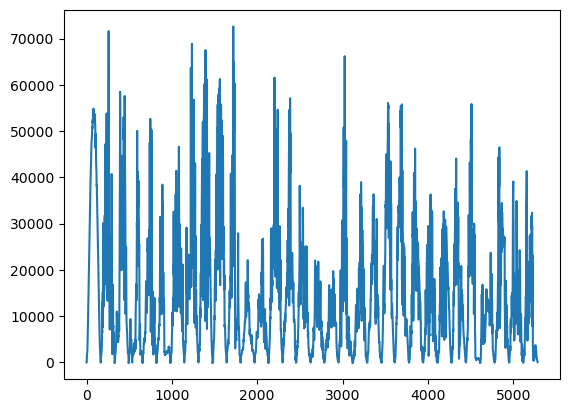

In [3]:
X_train_1["generationPower"].plot()

获取完pd.dataframe格式的数据之后构建数据集和测试集

In [4]:
# 对X_train_1, X_train_2, X_train_3, X_train_4, X_test进行预处理
# 将三个训练集合并在一起：
from sklearn.discriminant_analysis import StandardScaler


len_train_1 = len(X_train_1)
# len_train_2 = len(X_train_2)
# len_train_3 = len(X_train_3)
# len_train_4 = len(X_train_4)
# 保存每个训练集的长度以便后续进行数据划分
# X_train = pd.concat([X_train_1, X_train_2, X_train_3, X_train_4], ignore_index=True)
X_train = pd.concat([X_train_1], ignore_index=True)

def preprocess_data(df, if_train=True, scalers=None):
    """
    改进的预处理流程，对每个物理量分别进行归一化

    :param df: 输入的DataFrame
    :param if_train: 是否为训练数据
    :param scalers: 保存的归一化工具字典
    :return: 处理后的DataFrame和归一化工具字典
    """
    # 创建预处理工具字典（如果未提供）
    if scalers is None:
        scalers = {}

    # 1. 确保按时间排序
    df.sort_values("dateTime", inplace=True)

    # 2. 时间特征工程（不改变原始时间值）
    print("步骤1: 时间特征提取")
    df["dateTime"] = pd.to_datetime(df["dateTime"], unit='s', utc=True).dt.tz_convert('Asia/Shanghai')
    print(f"数据时间范围: {df['dateTime'].min()} 到 {df['dateTime'].max()}")
    # 基本时间特征 - 保留原始值
    df["hour"] = df["dateTime"].dt.hour.astype(int)  # 保持整型
    df["day_of_week"] = df["dateTime"].dt.dayofweek.astype(int)  # 0-6
    df["month"] = df["dateTime"].dt.month.astype(int)  # 1-12

    # 高级时间特征 - 使用数值表示（归一化0-1）
    df["is_weekend"] = (df["day_of_week"] >= 5).astype(int)
    # 将dateTime转换为时间戳（秒）
    df["timestamp"] = df["dateTime"].astype(np.int64) // 10**9  # 转换为秒级时间戳
    # 3. 处理缺失值
    print("\n步骤2: 缺失值处理")
    print(f"缺失值统计:\n{df.isnull().sum()}")

    # 线性插值 - 保留原始值范围
    for col in ["generationPower", "fullPowerHours"]:
        df[col] = df[col].interpolate(method="linear")

    # 4. 分别归一化处理（关键改进）
    print("\n步骤3: 分别归一化不同物理量")

    # 定义不同类型的特征及其归一化方式
    power_features = ["generationPower"]  # 功率类特征
    energy_features = ["generationValue"]  # 能量类特征
    duration_features = ["fullPowerHours"]  # 时间类特征
    time_features = ["hour", "day_of_week", "month"]  # 周期性时间特征

    # 归一化配置
    if if_train:
        # 训练集：创建归一化器并保存
        # 功率类特征：标准化处理（保持负值可能）
        scaler_power = StandardScaler()
        df[power_features] = scaler_power.fit_transform(df[power_features])
        scalers["power_scaler"] = scaler_power

        # 能量类特征：MinMax归一化到[0,1]
        scaler_energy = MinMaxScaler()
        df[energy_features] = scaler_energy.fit_transform(df[energy_features])
        scalers["energy_scaler"] = scaler_energy

        # 时间类特征：MinMax归一化到[0,1]
        scaler_duration = MinMaxScaler()
        df[duration_features] = scaler_duration.fit_transform(df[duration_features])
        scalers["duration_scaler"] = scaler_duration

        # 周期性时间特征：使用特定方式归一化
        for feature in time_features:
            # 对于周期性特征，使用正弦/余弦变换
            max_value = {"hour": 24, "day_of_week": 7, "month": 12}[feature]

            # 创建新列代替原始列
            df[f"{feature}_sin"] = np.sin(2 * np.pi * df[feature] / max_value)
            df[f"{feature}_cos"] = np.cos(2 * np.pi * df[feature] / max_value)

            # 保存转换参数
            scalers[f"time_{feature}_max"] = max_value

        # 删除原始时间特征
        df.drop(columns=time_features, inplace=True)
    else:
        # 测试集：应用训练集的归一化器
        # 功率特征
        if "power_scaler" in scalers:
            df[power_features] = scalers["power_scaler"].transform(df[power_features])
        else:
            raise ValueError("缺少功率归一化器")

        # 能量特征
        if "energy_scaler" in scalers:
            df[energy_features] = scalers["energy_scaler"].transform(df[energy_features])
        else:
            raise ValueError("缺少能量归一化器")

        # 时间特征
        if "duration_scaler" in scalers:
            df[duration_features] = scalers["duration_scaler"].transform(df[duration_features])
        else:
            raise ValueError("缺少时间归一化器")

        # 周期性时间特征转换
        for feature in time_features:
            if f"time_{feature}_max" in scalers:
                max_value = scalers[f"time_{feature}_max"]
                df[f"{feature}_sin"] = np.sin(2 * np.pi * df[feature] / max_value)
                df[f"{feature}_cos"] = np.cos(2 * np.pi * df[feature] / max_value)
            else:
                # 如果没有保存参数，使用新的
                max_value = {"hour": 24, "day_of_week": 7, "month": 12}[feature]
                df[f"{feature}_sin"] = np.sin(2 * np.pi * df[feature] / max_value)
                df[f"{feature}_cos"] = np.cos(2 * np.pi * df[feature] / max_value)
                scalers[f"time_{feature}_max"] = max_value

            df.drop(columns=feature, inplace=True)

    # 计算能源利用率（避免除零）
    # min_generation = df["generationPower"].min()
    # df["energy_utilization"] = df["useValue"] / (df["generationPower"] + abs(min_generation) + 0.00001)

    # 6. 清理特征
    print("\n步骤5: 清理特征")
    # 保留时间戳用于后续时间序列处理
    # df.drop(columns=['dateTime'], inplace=True, errors='ignore')

    print(f"处理后特征数: {len(df.columns)}")
    print(f"处理后的特征分别为: {df.columns.tolist()}")
    print(f"处理后数据量: {len(df)}")

    return df, scalers
# 预处理训练集

X_train, scalers = preprocess_data(X_train, if_train=True)
# 预处理测试集
X_test, _ = preprocess_data(X_test, if_train=False, scalers=scalers)
#将预处理后的数据保存为CSV文件
output_dir = "processed_data"
if not os.path.exists(output_dir):
    os.makedirs(output_dir)
save_dir = os.path.join(output_dir, f"station_{station_id}")
if not os.path.exists(save_dir):
    os.makedirs(save_dir)

X_train.to_csv(os.path.join(save_dir, "X_train.csv"), index=False)
X_test.to_csv(os.path.join(save_dir, "X_test.csv"), index=False)
# 保存归一化工具
scaler_file = "scalers.json"
if not os.path.exists(scaler_file):
    with open(scaler_file, 'w') as f:
        json.dump({k: v.get_params() if hasattr(v, 'get_params') else v for k, v in scalers.items()}, f)
else:
    print(f"归一化工具文件 {scaler_file} 已存在，跳过保存。")
# 将训练集依旧分为四个部分

X_train_1 = X_train.iloc[:len_train_1].reset_index(drop=True)
# X_train_2 = X_train.iloc[len_train_1:len_train_1 + len_train_2].reset_index(drop=True)
# X_train_3 = X_train.iloc[len_train_1 + len_train_2:len_train_1 + len_train_2 + len_train_3].reset_index(drop=True)
# X_train_4 = X_train.iloc[len_train_1 + len_train_2 + len_train_3:].reset_index(drop=True)
# 保存分割后的训练集
X_train_1.to_csv(os.path.join(output_dir,f"station_{station_id}", "X_train_1.csv"), index=False)
# X_train_2.to_csv(os.path.join(output_dir, "X_train_2.csv"), index=False)
# X_train_3.to_csv(os.path.join(output_dir, "X_train_3.csv"), index=False)
# X_train_4.to_csv(os.path.join(output_dir, "X_train_4.csv"), index=False)
print("数据预处理完成，已保存为CSV文件。")

步骤1: 时间特征提取
数据时间范围: 2025-05-13 05:45:00+08:00 到 2025-06-13 19:40:00+08:00

步骤2: 缺失值处理
缺失值统计:
acPowerHours           0
fullPowerHours         0
generationValue        0
dateTime               0
generationPower       23
generationCapacity    23
hour                   0
day_of_week            0
month                  0
is_weekend             0
timestamp              0
dtype: int64

步骤3: 分别归一化不同物理量

步骤5: 清理特征
处理后特征数: 14
处理后的特征分别为: ['acPowerHours', 'fullPowerHours', 'generationValue', 'dateTime', 'generationPower', 'generationCapacity', 'is_weekend', 'timestamp', 'hour_sin', 'hour_cos', 'day_of_week_sin', 'day_of_week_cos', 'month_sin', 'month_cos']
处理后数据量: 5286
步骤1: 时间特征提取
数据时间范围: 2025-06-13 05:40:00+08:00 到 2025-06-22 19:40:00+08:00

步骤2: 缺失值处理
缺失值统计:
acPowerHours          0
fullPowerHours        0
generationValue       0
dateTime              0
generationPower       7
generationCapacity    7
hour                  0
day_of_week           0
month                 0
is_weekend            0
t

In [16]:
X_train
# X_test

,acPowerHours,fullPowerHours,generationValue,dateTime,generationPower,generationCapacity,is_weekend,timestamp,hour_sin,hour_cos,day_of_week_sin,day_of_week_cos,month_sin,month_cos
0,12.4303,1.000000,1.000000,2025-05-13 05:45:00+08:00,NaN,NaN,0,1747086300,0.965926,2.588190e-01,0.781831,0.623490,5.000000e-01,-0.866025
1,12.4303,1.000000,1.000000,2025-05-13 05:50:00+08:00,-1.088617,0.00000,0,1747086600,0.965926,2.588190e-01,0.781831,0.623490,5.000000e-01,-0.866025
2,12.4303,1.000000,1.000000,2025-05-13 05:55:00+08:00,-1.088617,0.00000,0,1747086900,0.965926,2.588190e-01,0.781831,0.623490,5.000000e-01,-0.866025
3,12.4303,1.000000,1.000000,2025-05-13 06:00:00+08:00,-0.968115,0.04977,0,1747087200,1.000000,6.123234e-17,0.781831,0.623490,5.000000e-01,-0.866025
4,12.4303,1.000000,1.000000,2025-05-13 06:05:00+08:00,-0.968115,0.00000,0,1747087500,1.000000,6.123234e-17,0.781831,0.623490,5.000000e-01,-0.866025
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5281,7.0303,0.452367,0.452366,2025-06-13 19:20:00+08:00,-1.061763,0.00800,0,1749813600,-0.965926,2.588190e-01,-0.433884,-0.900969,1.224647e-16,-1.000000
5282,7.0303,0.452367,0.452366,2025-06-13 19:25:00+08:00,-1.069247,0.00582,0,1749813900,-0.965926,2.588190e-01,-0.433884,-0.900969,1.224647e-16,-1.000000
5283,7.0303,0.452367,0.452366,2025-06-13 19:30:00+08:00,-1.074530,0.00388,0,1749814200,-0.965926,2.588190e-01,-0.433884,-0.900969,1.224647e-16,-1.000000
5284,7.0303,0.452367,0.452366,2025-06-13 19:35:00+08:00,-1.079225,0.00000,0,1749814500,-0.965926,2.588190e-01,-0.433884,-0.900969,1.224647e-16,-1.000000


完成数据归一化和预处理之后，将其转换为NeuralProphet所需的数据格式

In [17]:
def load_and_prepare_data(train_path, test_path):
    """
    加载并准备NeuralProphet所需的数据格式
    """
    # 读取数据
    train_df = pd.read_csv(train_path)
    test_df = pd.read_csv(test_path)

    print(f"训练集大小: {len(train_df)}")
    print(f"测试集大小: {len(test_df)}")

    # # 时间格式转换
    train_df["dateTime"] = pd.to_datetime(train_df["dateTime"])
    test_df["dateTime"] = pd.to_datetime(test_df["dateTime"])
    
    # 重命名列为NeuralProphet需要的格式
    # 保留时间戳作为ds，发电功率作为y
    # 其他特征作为外部回归量
    feature_columns = [col for col in train_df.columns if col not in ["dateTime", "generationPower"]]

    # 重命名列
    train_df.rename(columns={"dateTime": "ds", "generationPower": "y"}, inplace=True)
    test_df.rename(columns={"dateTime": "ds", "generationPower": "y"}, inplace=True)

    # 确保时间排序
    train_df = train_df.sort_values("ds").reset_index(drop=True)
    test_df = test_df.sort_values("ds").reset_index(drop=True)
    #打印训练集和测试集第一天和最后一天的时间戳
    print(f"训练集第一天: {train_df['ds'].min()}, 最后一天: {train_df['ds'].max()}")
    print(f"测试集第一天: {test_df['ds'].min()}, 最后一天: {test_df['ds'].max()}")
    # 验证时间连续性
    time_diff_train = (train_df["ds"].max() - train_df["ds"].min()).days
    time_diff_test = (test_df["ds"].max() - test_df["ds"].min()).days
    print(f"训练集时间跨度: {time_diff_train} 天")
    print(f"测试集时间跨度: {time_diff_test} 天")

    return train_df, test_df, feature_columns
train_path = os.path.join(save_dir,"X_train.csv")
test_path = os.path.join(save_dir, "X_test.csv")
train_df, test_df, feature_columns = load_and_prepare_data(train_path, test_path)
#将训练集划分为四个部分
train_df_1 = train_df.iloc[:len_train_1].reset_index(drop=True)
# train_df_2 = train_df.iloc[len_train_1:len_train_1 + len_train_2].reset_index(drop=True)
# train_df_3 = train_df.iloc[len_train_1 + len_train_2:len_train_1 + len_train_2 + len_train_3].reset_index(drop=True)
# train_df_4 = train_df.iloc[len_train_1 + len_train_2 + len_train_3:].reset_index(drop=True)

训练集大小: 5286
测试集大小: 1653
训练集第一天: 2025-05-13 05:45:00+08:00, 最后一天: 2025-06-13 19:40:00+08:00
测试集第一天: 2025-06-13 05:40:00+08:00, 最后一天: 2025-06-22 19:40:00+08:00
训练集时间跨度: 31 天
测试集时间跨度: 9 天


In [7]:
# 创建NeuralProphet模型
from neuralprophet import NeuralProphet
def create_neuralprophet_model(config, feature_columns):
    """
    创建并配置NeuralProphet模型
    """
    # 基本配置
    model = NeuralProphet(
        n_forecasts=config["forecast_horizon"],  # 预测步长
        n_lags=config["history_window"],  # 历史窗口大小
        learning_rate=config["learning_rate"],
        loss_func=config["loss_func"],

        yearly_seasonality=True,
        weekly_seasonality=True,
        daily_seasonality=True,
        seasonality_mode=config["seasonality_mode"],
        quantiles=config["quantiles"],
    )

    # 添加外部回归量
    for feature in feature_columns:
        model = model.add_lagged_regressor(feature)
        print(f"添加外部回归量: {feature}")
    return model

c:\Users\12693\anaconda3\lib\site-packages\torchvision\io\image.py:13: UserWarning: Failed to load image Python extension: Could not find module 'C:\Users\12693\anaconda3\Lib\site-packages\torchvision\image.pyd' (or one of its dependencies). Try using the full path with constructor syntax.
  warn(f"Failed to load image Python extension: {e}")
Importing plotly failed. Interactive plots will not work.
Importing plotly failed. Interactive plots will not work.


In [8]:
# 导入必要的库
print(f"train_df_1:{train_df_1.shape}")
# print(f"train_df_2:{train_df_2.shape}")
# print(f"train_df_3:{train_df_3.shape}")
# print(f"train_df_4:{train_df_4.shape}")
print(f"test_df:{test_df.shape}")
train_df_1.head()

train_df_1:(5286, 14)
test_df:(1653, 14)


,acPowerHours,fullPowerHours,generationValue,ds,y,generationCapacity,is_weekend,timestamp,hour_sin,hour_cos,day_of_week_sin,day_of_week_cos,month_sin,month_cos
0,12.4303,1.0,1.0,2025-05-13 05:45:00+08:00,NaN,NaN,0,1747086300,0.965926,2.588190e-01,0.781831,0.62349,0.5,-0.866025
1,12.4303,1.0,1.0,2025-05-13 05:50:00+08:00,-1.088617,0.00000,0,1747086600,0.965926,2.588190e-01,0.781831,0.62349,0.5,-0.866025
2,12.4303,1.0,1.0,2025-05-13 05:55:00+08:00,-1.088617,0.00000,0,1747086900,0.965926,2.588190e-01,0.781831,0.62349,0.5,-0.866025
3,12.4303,1.0,1.0,2025-05-13 06:00:00+08:00,-0.968115,0.04977,0,1747087200,1.000000,6.123234e-17,0.781831,0.62349,0.5,-0.866025
4,12.4303,1.0,1.0,2025-05-13 06:05:00+08:00,-0.968115,0.00000,0,1747087500,1.000000,6.123234e-17,0.781831,0.62349,0.5,-0.866025


In [10]:
# 配置NeuralProphet模型参数
config = {
    "forecast_horizon": 4 * 12,  # 预测未来24小时
    "history_window": 24 * 12,  # 使用过去48小时的数据进行预测
    "learning_rate": 1e-3,
    "loss_func":"MSE",
    "seasonality_mode": "additive",  # 可选：'additive' 或 'multiplicative'
    "quantiles": [0.1, 0.5, 0.9],  # 用于预测区间
}
model = create_neuralprophet_model(config, feature_columns)
print("NeuralProphet model created with config:", config)

INFO - (NP.forecaster.add_lagged_regressor) - n_lags = 'auto', number of lags for regressor is set to Autoregression number of lags (288)
INFO - (NP.forecaster.add_lagged_regressor) - n_lags = 'auto', number of lags for regressor is set to Autoregression number of lags (288)
INFO - (NP.forecaster.add_lagged_regressor) - n_lags = 'auto', number of lags for regressor is set to Autoregression number of lags (288)
INFO - (NP.forecaster.add_lagged_regressor) - n_lags = 'auto', number of lags for regressor is set to Autoregression number of lags (288)
INFO - (NP.forecaster.add_lagged_regressor) - n_lags = 'auto', number of lags for regressor is set to Autoregression number of lags (288)
INFO - (NP.forecaster.add_lagged_regressor) - n_lags = 'auto', number of lags for regressor is set to Autoregression number of lags (288)
INFO - (NP.forecaster.add_lagged_regressor) - n_lags = 'auto', number of lags for regressor is set to Autoregression number of lags (288)
INFO - (NP.forecaster.add_lagged_r

添加外部回归量: acPowerHours
添加外部回归量: fullPowerHours
添加外部回归量: generationValue
添加外部回归量: generationCapacity
添加外部回归量: is_weekend
添加外部回归量: timestamp
添加外部回归量: hour_sin
添加外部回归量: hour_cos
添加外部回归量: day_of_week_sin
添加外部回归量: day_of_week_cos
添加外部回归量: month_sin
添加外部回归量: month_cos
NeuralProphet model created with config: {'forecast_horizon': 48, 'history_window': 288, 'learning_rate': 0.001, 'loss_func': 'MSE', 'seasonality_mode': 'additive', 'quantiles': [0.1, 0.5, 0.9]}


In [11]:
singular = [c for c in train_df_1.columns if train_df_1[c].nunique() < 2]
print("常数列：", singular)
# singular = ['useValue', 'buyValue']

常数列： []


In [12]:
#创建好模型之后，进行训练：
def train_model(model, train_df, epochs=5, batch_size=32):
    """
    训练NeuralProphet模型
    """
    print(f"开始训练模型，训练集大小: {len(train_df)}")
    model.fit(train_df, freq='H', epochs=epochs, batch_size=batch_size)
    print("模型训练完成")
    return model
# 训练模型

train_df_clean = train_df_1.drop(columns=singular)

model = train_model(model, train_df_clean, epochs=100, batch_size=64)
# 保存模型
model_path = "neuralprophet_model.pth"
torch.save(model.state_dict(), model_path)
print(f"模型已保存到 {model_path}")


WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequency) - Major frequency 5T corresponds to 99.111% of the data.
WARNING - (NP.df_utils._infer_frequency) - Defined frequency H is different than major frequency 5T
WARNING - (NP.data.processing._handle_missing_data) - 1 missing values in column y were detected in total. 
INFO - (NP.data.processing._handle_missing_data) - 1 NaN values in column y were auto-imputed.
WARNING - (NP.data.processing._handle_missing_data) - 23 missing values in column generationCapacity were detected in total. 
INFO - (NP.data.processing._handle_missing_data) - 23 NaN values in column generationCapacity were auto-imputed.
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.


开始训练模型，训练集大小: 5286


Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

WARNING - (py.warnings._showwarnmsg) - c:\Users\12693\anaconda3\lib\site-packages\pytorch_lightning\utilities\data.py:79: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 64. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.

WARNING - (py.warnings._showwarnmsg) - c:\Users\12693\anaconda3\lib\site-packages\pytorch_lightning\utilities\data.py:79: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 23. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.



模型训练完成
模型已保存到 neuralprophet_model.pth


In [23]:
test_df.values.shape
train_df.values.shape

(5286, 14)

In [18]:
# 使用模型进行预测
def predict(model, test_df):
    """
    使用NeuralProphet模型进行预测
    """
    print(f"开始预测，测试集大小: {len(test_df)}")
    future = model.make_future_dataframe(test_df, periods=config["forecast_horizon"], n_historic_predictions=True)
    forecast = model.predict(future)
    print("预测完成")
    return forecast
# 进行预测
forecast = predict(model, test_df)
#对所有结果进行反归一化：

# 保存预测结果
forecast_path = "neuralprophet_forecast.csv"
forecast.to_csv(forecast_path, index=False)
print(f"预测结果已保存到 {forecast_path}")
# 首先对y的结果进行反归一化，检查是否真的是观测值：
def inverse_normalize_y(forecast, scalers):
    """
    对预测结果中的y值进行反归一化，同时对预测结果也进行反归一化
    """
    if "power_scaler" in scalers:
        # 反归一化功率
        power_scaler = scalers["power_scaler"]
        forecast["y"] = power_scaler.inverse_transform(forecast[["y"]])
        # 反归一化其他功率特征
        for col in forecast.columns:
            if col.startswith("yhat"):
                forecast[col] = power_scaler.inverse_transform(forecast[[col]])
                print(f"归一化了{col}")
        
    else:
        raise ValueError("缺少能量归一化器")
    #此外时间不对，2025.4.25 16：00对应的是2025.4.16 00：00：
    #直接加上八个小时即可：
    # forecast["ds"] = forecast["ds"] + pd.Timedelta(hours=16)
    return forecast
# 对预测结果进行反归一化
# 打印一开始的ds数据
print(f"换为北京市区之前预测结果的时间戳范围: {forecast['ds'].min()} 到 {forecast['ds'].max()}")
forecast = inverse_normalize_y(forecast, scalers)
print(forecast)
forecast["ds"] = forecast["ds"] + pd.Timedelta(hours=8)  # 调整时间戳
print(f"换为北京市区之后预测结果的时间戳范围: {forecast['ds'].min()} 到 {forecast['ds'].max()}")
#使用to_csv保存的时候要使用调整之后的时间戳
#打印forcaset的列名：
print(f"预测结果的列名: {forecast.columns.tolist()}")
forecast_inverse_path = "prophet_forecast_inverse.csv"
forecast.to_csv(forecast_inverse_path, index=False)


INFO - (NP.df_utils._infer_frequency) - Major frequency 5T corresponds to 99.214% of the data.
WARNING - (NP.df_utils._infer_frequency) - Defined frequency H is different than major frequency 5T
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency 5T corresponds to 96.414% of the data.
WARNING - (NP.df_utils._infer_frequency) - Defined frequency H is different than major frequency 5T
INFO - (NP.df_utils._infer_frequency) - Major frequency 5T corresponds to 96.414% of the data.
WARNING - (NP.df_utils._infer_frequency) - Defined frequency H is different than major frequency 5T
INFO - (NP.data.processing._handle_missing_data) - Dropped 48 rows at the end with NaNs in 'y' column.
WARNING - (NP.data.processing._handle_missing_data) - 1 missing values in column y were detected in total. 
INFO - (NP.data.processing._handle_missing_data) - 1 NaN values in column y were auto-imputed.
WARNING - (NP.data.process

开始预测，测试集大小: 1653


Predicting: |          | 0/? [00:00<?, ?it/s]

RuntimeError: mat1 and mat2 shapes cannot be multiplied (1024x2880 and 3456x144)

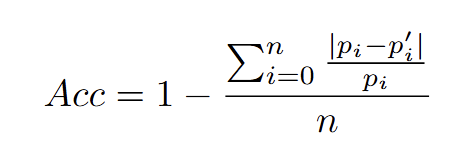

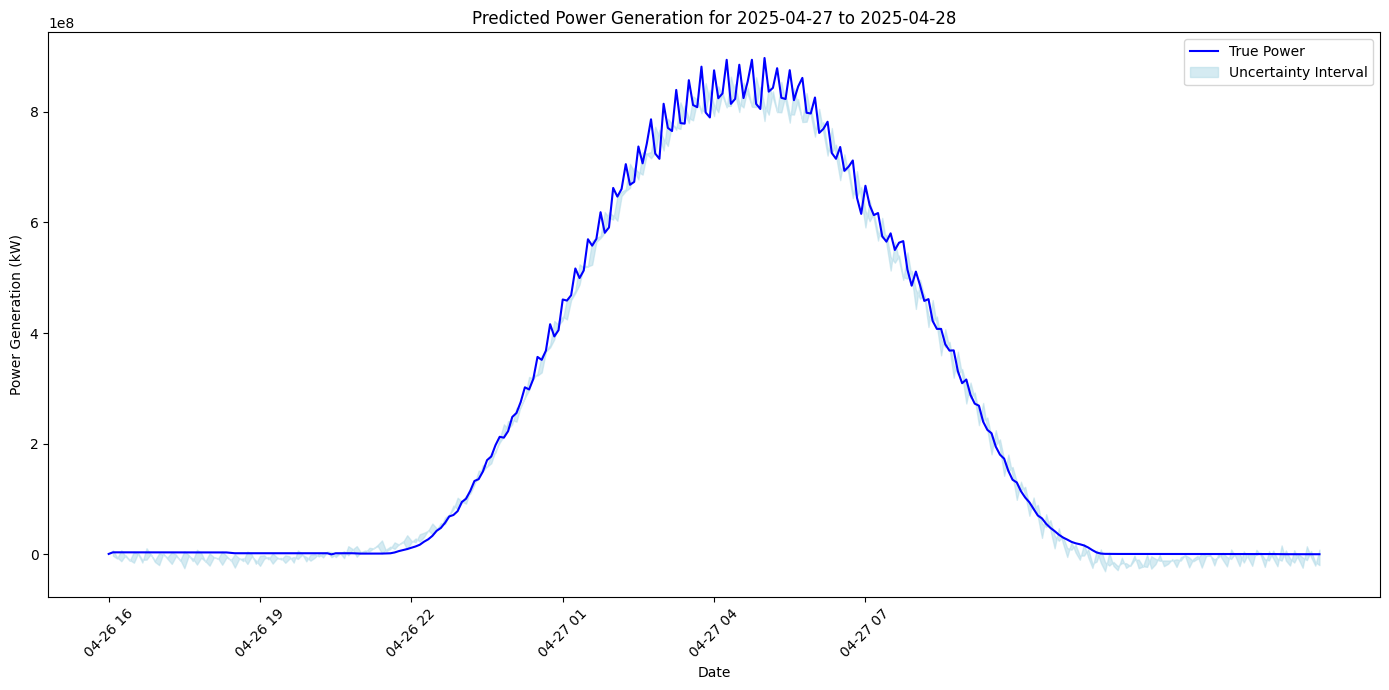

                     ds             y        yhat1         yhat2       yhat3  \
288 2025-04-27 00:00:00  8.399124e+05 -1709931.375           NaN         NaN   
289 2025-04-27 00:05:00  3.753465e+06 -2290027.250  7.452820e+06         NaN   
290 2025-04-27 00:10:00  3.751563e+06 -7431019.500 -5.162348e+06 -16002923.0   
291 2025-04-27 00:15:00  3.748418e+06  7586452.500 -1.232574e+07 -22419308.0   
292 2025-04-27 00:20:00  3.751143e+06 -3359595.250 -1.606507e+06 -30410092.0   

          yhat4       yhat5  yhat6  yhat7  yhat8  ...  \
288         NaN         NaN    NaN    NaN    NaN  ...   
289         NaN         NaN    NaN    NaN    NaN  ...   
290         NaN         NaN    NaN    NaN    NaN  ...   
291  -7495531.5         NaN    NaN    NaN    NaN  ...   
292 -17898860.0 -13764459.0    NaN    NaN    NaN  ...   

     lagged_regressor_energy_utilization43  \
288                                    NaN   
289                                    NaN   
290                                   

In [ ]:
#进行可视化：针对2025年4月27日-4月28日的24小时进行可视化：
start_date = "2025-04-27"
end_date = "2025-04-28"
# 过滤预测结果
filtered_forecast = forecast[(forecast["ds"] >= start_date) & (forecast["ds"] <= end_date)]
# 绘制预测结果
plt.figure(figsize=(14, 7))
plt.plot(filtered_forecast["ds"], filtered_forecast["y"], label="True Power", color='blue')
plt.fill_between(filtered_forecast["ds"], 
                 filtered_forecast["yhat1"], 
                 filtered_forecast["yhat2"], 
                 color='lightblue', alpha=0.5, label='Uncertainty Interval')
plt.title("Predicted Power Generation for 2025-04-27 to 2025-04-28")
plt.xlabel("Date")
plt.ylabel("Power Generation (kW)")
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.savefig("neuralprophet_prediction_plot.png")
plt.show()
# 打印预测结果的前几行
#打印27日预测结果的前几行：
print(filtered_forecast.head())
#计算早上八点-下午六点功率预测的准确率：
start_time = "2025-04-27 08:00:00"
end_time = "2025-04-27 18:00:00"
# 过滤时间范围内的预测结果
filtered_forecast_time = filtered_forecast[(filtered_forecast["ds"] >= start_time) & (filtered_forecast["ds"] <= end_time)]
n=len(filtered_forecast_time)
#计算相对误差的和：
relative_error_sum = np.sum(np.abs(filtered_forecast_time["y"] - filtered_forecast_time["yhat1"]) / filtered_forecast_time["y"])
acc=1-relative_error_sum/n
print(f"2025年4月27日早上八点到下午六点的功率预测准确率: {acc:.2%}")


WARNING - (py.warnings._showwarnmsg) - /tmp/ipykernel_1778/308754505.py:70: UserWarning: Glyph 21151 (\N{CJK UNIFIED IDEOGRAPH-529F}) missing from font(s) DejaVu Sans.
  plt.tight_layout()

WARNING - (py.warnings._showwarnmsg) - /tmp/ipykernel_1778/308754505.py:70: UserWarning: Glyph 29575 (\N{CJK UNIFIED IDEOGRAPH-7387}) missing from font(s) DejaVu Sans.
  plt.tight_layout()

WARNING - (py.warnings._showwarnmsg) - /tmp/ipykernel_1778/308754505.py:70: UserWarning: Glyph 33267 (\N{CJK UNIFIED IDEOGRAPH-81F3}) missing from font(s) DejaVu Sans.
  plt.tight_layout()

WARNING - (py.warnings._showwarnmsg) - /tmp/ipykernel_1778/308754505.py:70: UserWarning: Glyph 20809 (\N{CJK UNIFIED IDEOGRAPH-5149}) missing from font(s) DejaVu Sans.
  plt.tight_layout()

WARNING - (py.warnings._showwarnmsg) - /tmp/ipykernel_1778/308754505.py:70: UserWarning: Glyph 20239 (\N{CJK UNIFIED IDEOGRAPH-4F0F}) missing from font(s) DejaVu Sans.
  plt.tight_layout()

WARNING - (py.warnings._showwarnmsg) - /tmp/ipyker

WARNING - (py.warnings._showwarnmsg) - /tmp/ipykernel_1778/308754505.py:71: UserWarning: Glyph 21151 (\N{CJK UNIFIED IDEOGRAPH-529F}) missing from font(s) DejaVu Sans.
  plt.savefig("neuralprophet_prediction_plot.png")

WARNING - (py.warnings._showwarnmsg) - /tmp/ipykernel_1778/308754505.py:71: UserWarning: Glyph 29575 (\N{CJK UNIFIED IDEOGRAPH-7387}) missing from font(s) DejaVu Sans.
  plt.savefig("neuralprophet_prediction_plot.png")

WARNING - (py.warnings._showwarnmsg) - /tmp/ipykernel_1778/308754505.py:71: UserWarning: Glyph 23792 (\N{CJK UNIFIED IDEOGRAPH-5CF0}) missing from font(s) DejaVu Sans.
  plt.savefig("neuralprophet_prediction_plot.png")

WARNING - (py.warnings._showwarnmsg) - /tmp/ipykernel_1778/308754505.py:71: UserWarning: Glyph 20540 (\N{CJK UNIFIED IDEOGRAPH-503C}) missing from font(s) DejaVu Sans.
  plt.savefig("neuralprophet_prediction_plot.png")

WARNING - (py.warnings._showwarnmsg) - /tmp/ipykernel_1778/308754505.py:71: UserWarning: Glyph 33267 (\N{CJK UNIFIED IDE

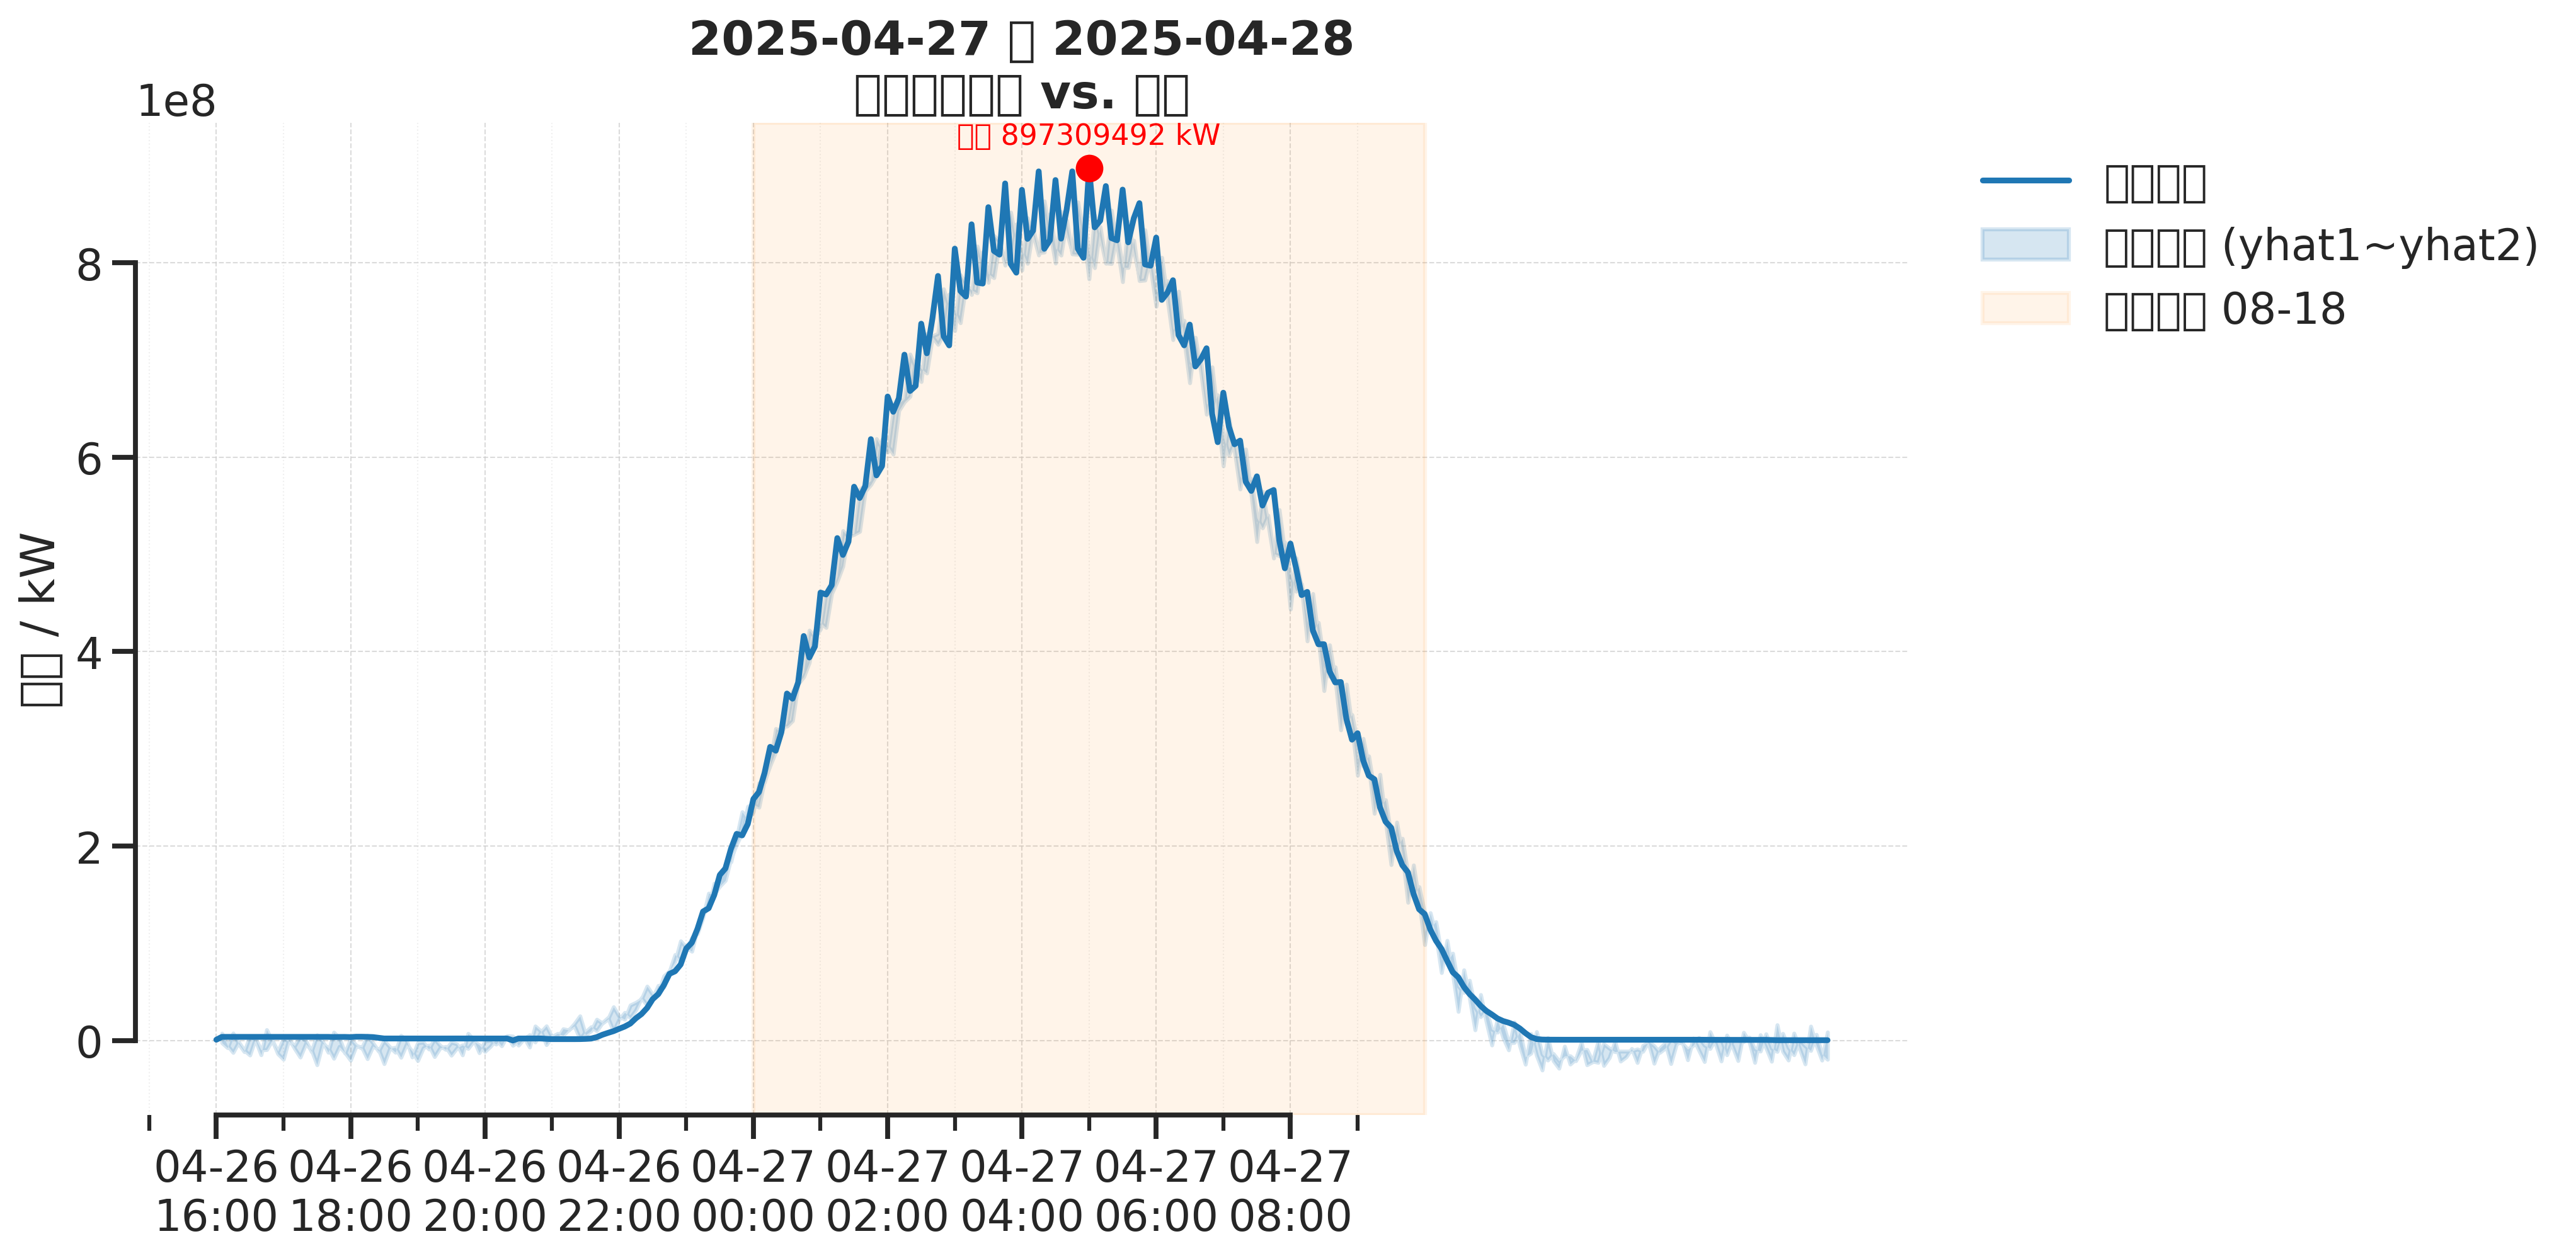

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.font_manager as fm
import pandas as pd
import seaborn as sns
import numpy as np

# ================= 1. 字体 & 样式 =================
# (如果系统已有 SimHei / PingFang / Microsoft YaHei，可直接写对应名字)
# font_path = "./NotoSansCJKsc-Regular.otf"      # 确保文件存在
# font_prop  = fm.FontProperties(fname=font_path)

# plt.rcParams["font.family"] = font_prop.get_name()
# plt.rcParams["axes.unicode_minus"] = False     # 负号显示正常
sns.set_style("ticks")
sns.set_context("talk")                        # 字体整体再放大一点

# ================= 2. 过滤数据 =================
start_date = "2025-04-27"
end_date   = "2025-04-28"
mask = (forecast["ds"] >= start_date) & (forecast["ds"] <= end_date)
filtered = forecast.loc[mask]

# ================= 3. 作图 =================
fig, ax = plt.subplots(figsize=(14, 7), dpi=300)

# 主折线（真实功率）
ax.plot(filtered["ds"], filtered["y"],
        label="实际功率", color="#1f77b4", linewidth=2.2)

# 置信区间
ax.fill_between(filtered["ds"],
                filtered["yhat1"], filtered["yhat2"],
                color="#1f77b4", alpha=0.18,
                label="预测区间 (yhat1~yhat2)")

# 高亮 08-18 点区段
day_start = pd.Timestamp("2025-04-27 08:00:00")
day_end   = pd.Timestamp("2025-04-27 18:00:00")
ax.axvspan(day_start, day_end,
           color="#ff962a", alpha=0.10, label="工作时段 08-18")

# 峰值标注
peak_idx = filtered["y"].idxmax()
peak_x   = filtered.loc[peak_idx, "ds"]
peak_y   = filtered.loc[peak_idx, "y"]
ax.scatter(peak_x, peak_y, color="red", zorder=5)
ax.text(peak_x, peak_y*1.02, f"峰值 {peak_y:.0f} kW",
        ha="center", va="bottom", fontsize=11, color="red")

# ================= 4. 轴&网格 =================
# X 轴：2 小时一个主刻度，1 小时灰色细刻度
ax.xaxis.set_major_locator(mdates.HourLocator(interval=2))
ax.xaxis.set_minor_locator(mdates.HourLocator(interval=1))
ax.xaxis.set_major_formatter(mdates.DateFormatter("%m-%d\n%H:%M"))

ax.grid(which="major", axis="both",
        linestyle="--", linewidth=0.5, alpha=0.7)
ax.grid(which="minor", axis="x",
        linestyle=":", linewidth=0.5, alpha=0.3)

ax.set_ylabel("功率 / kW")
ax.set_title("2025-04-27 至 2025-04-28\n光伏功率预测 vs. 实测", fontsize=18, weight="bold")

# 右侧图例
ax.legend(bbox_to_anchor=(1.02, 1), loc="upper left", frameon=False)

sns.despine(trim=True)  # 去掉右/上脊

plt.tight_layout()
plt.savefig("neuralprophet_prediction_plot.png")
plt.show()
